In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns', None, "display.max_rows", None)

# Read in csv
houses = pd.read_csv("../data/train.csv", index_col = "Id")

# Adjust MSSubClass to string
houses["MSSubClass"] = houses["MSSubClass"].astype('str')

# Convert Alley to Factor
houses["Alley"] = houses["Alley"].map(lambda x: 1 if x is True else 0)

# Impute missing GarageYrBlt from year house built
houses.loc[pd.isna(houses.GarageYrBlt), "GarageYrBlt"] = houses.loc[pd.isna(houses.GarageYrBlt), "YearBuilt"]

# Bin LotConfig to impute missing LotFrontage
mean_frontage = dict(houses.groupby("LotConfig")["LotFrontage"].mean())
mean_frontage
houses.loc[pd.isna(houses["LotFrontage"]), "LotFrontage"] = houses.loc[pd.isna(houses["LotFrontage"]), "LotConfig"].replace(mean_frontage)
houses = houses.drop("LotConfig", axis = 1)

# Convert Fireplace Quality to Scale
houses["FireplaceQu"] = houses["FireplaceQu"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)

# Convert Exterior Quality and Condition to Scale
houses["ExterQual"] = houses["ExterQual"].apply(lambda x: 0 if x == "Po" else 1 if x == "Fa" else 2 if x == "TA" else 3 if x == "Gd" else 5)
houses["ExterCond"] = houses["ExterCond"].apply(lambda x: 0 if x == "Po" else 1 if x == "Fa" else 2 if x == "TA" else 3 if x == "Gd" else 5)

# Convert Basement Quality and Condition to Scale
houses["BsmtQual"] = houses["BsmtQual"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)
houses["BsmtCond"] = houses["BsmtCond"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)
houses["BsmtExposure"] = houses["BsmtExposure"].apply(lambda x: 0 if x == False else 1 if x == "No" else 2 if x == "Mn" else 3 if x == "Av" else 4)
houses["BsmtFinType1"] = houses["BsmtFinType1"].apply(lambda x: 0 if x == False else 1 if x == "Unf" else 2 if x == "LwQ" else 3 if x == "Rec" else 4 if x == "BLQ" else 5 if x == "ALQ" else 6)
houses["BsmtFinType2"] = houses["BsmtFinType2"].apply(lambda x: 0 if x == False else 1 if x == "Unf" else 2 if x == "LwQ" else 3 if x == "Rec" else 4 if x == "BLQ" else 5 if x == "ALQ" else 6)
houses["BsmtUnfSF"] = houses["BsmtUnfSF"].apply(lambda x: 0 if "NaN" else x)
houses["TotalBsmtSF"] = houses["TotalBsmtSF"].apply(lambda x: 0 if "NaN" else x)
houses["BsmtFullBath"] = houses["BsmtFullBath"].apply(lambda x: 0 if "NaN" else x)
houses["BsmtHalfBath"] = houses["BsmtHalfBath"].apply(lambda x: 0 if "NaN" else x)

# Convert Heating, Kitchen, and Garage Quality and Finish to Scale
houses["HeatingQC"] = houses["HeatingQC"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)
houses["KitchenQual"] = houses["KitchenQual"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)
houses["GarageQual"] = houses["GarageQual"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)
houses["GarageFinish"] = houses["GarageFinish"].apply(lambda x: 0 if x == False else 1 if x == "Unf" else 2 if x == "RFn" else 3)

# Accomodate NAs in Garage Type
houses["GarageType"] = houses["GarageType"].apply(lambda x: "None" if "NaN" else x)
houses["GarageArea"] = houses["GarageArea"].apply(lambda x: 0 if "NaN" else x)

# Feature Engineer total Porch/Deck Area
houses["TotalPorchSqft"] = houses["WoodDeckSF"] + houses["OpenPorchSF"] + houses["EnclosedPorch"] + houses["3SsnPorch"] + houses["ScreenPorch"]

# Drop Rows with NA (9 total) from Electrical, MasVnrType, and MasVnrArea
houses = houses[~pd.isna(houses["Electrical"])]
houses = houses[~pd.isna(houses["MasVnrType"])]

# Drop Columns
houses = houses.drop(["MiscFeature", "Fence", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", 
                      "PoolArea", "PoolQC", "GarageCond", 
                      "GarageCars", "BsmtFinSF1", "BsmtFinSF2"], axis=1)

# houses.to_csv("houses")
# houses.dtypes
# dict(houses.isna().sum())
houses.head(10)
# houses.shape

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,PavedDrive,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalPorchSqft
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000000,8450,Pave,0,Reg,Lvl,AllPub,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,2,PConc,4,3,1,6,1,0,0,GasA,5,Y,SBrkr,856,854,0,1710,0,0,2,1,3,1,4,8,Typ,0,5,None,2003.0,2,0,3,Y,0,2,2008,WD,Normal,208500,61
2,20,RL,80.000000,9600,Pave,0,Reg,Lvl,AllPub,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,CBlock,4,3,4,5,1,0,0,GasA,5,Y,SBrkr,1262,0,0,1262,0,0,2,0,3,1,3,6,Typ,1,3,None,1976.0,2,0,3,Y,0,5,2007,WD,Normal,181500,298
3,60,RL,68.000000,11250,Pave,0,IR1,Lvl,AllPub,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,2,PConc,4,3,2,6,1,0,0,GasA,5,Y,SBrkr,920,866,0,1786,0,0,2,1,3,1,4,6,Typ,1,3,None,2001.0,2,0,3,Y,0,9,2008,WD,Normal,223500,42
4,70,RL,60.000000,9550,Pave,0,IR1,Lvl,AllPub,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,3,4,1,5,1,0,0,GasA,4,Y,SBrkr,961,756,0,1717,0,0,1,0,3,1,4,7,Typ,1,4,None,1998.0,1,0,3,Y,0,2,2006,WD,Abnorml,140000,307
5,60,RL,84.000000,14260,Pave,0,IR1,Lvl,AllPub,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,2,PConc,4,3,3,6,1,0,0,GasA,5,Y,SBrkr,1145,1053,0,2198,0,0,2,1,4,1,4,9,Typ,1,3,None,2000.0,2,0,3,Y,0,12,2008,WD,Normal,250000,276
6,50,RL,85.000000,14115,Pave,0,IR1,Lvl,AllPub,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,2,Wood,4,3,1,6,1,0,0,GasA,5,Y,SBrkr,796,566,0,1362,0,0,1,1,1,1,3,5,Typ,0,5,None,1993.0,1,0,3,Y,700,10,2009,WD,Normal,143000,390
7,20,RL,75.000000,10084,Pave,0,Reg,Lvl,AllPub,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,3,2,PConc,5,3,3,6,1,0,0,GasA,5,Y,SBrkr,1694,0,0,1694,0,0,2,0,3,1,4,7,Typ,1,4,None,2004.0,2,0,3,Y,0,8,2007,WD,Normal,307000,312
8,60,RL,84.039801,10382,Pave,0,IR1,Lvl,AllPub,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,2,2,CBlock,4,3,2,5,4,0,0,GasA,5,Y,SBrkr,1107,983,0,2090,0,0,2,1,3,1,3,7,Typ,2,3,None,1973.0,2,0,3,Y,350,11,2009,WD,Normal,200000,667
9,50,RM,51.000000,6120,Pave,0,Reg,Lvl,AllPub,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,2,2,BrkTil,3,3,1,1,1,0,0,GasA,4,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,3,8,Min1,2,3,None,1931.0,1,0,2,Y,0,4,2008,WD,Abnorml,129900,295


In [128]:
# Read in TEST csv
test_houses = pd.read_csv("../data/test.csv", index_col = "Id")
test_index = test_houses[["Alley"]].fillna(0)

# Adjust MSSubClass to string
test_houses["MSSubClass"] = test_houses["MSSubClass"].astype('str')

# Convert Alley to Factor
test_houses["Alley"] = test_houses["Alley"].map(lambda x: 1 if x is True else 0)

# Impute missing GarageYrBlt from year house built
test_houses.loc[pd.isna(test_houses.GarageYrBlt), "GarageYrBlt"] = test_houses.loc[pd.isna(test_houses.GarageYrBlt), "YearBuilt"]

# Bin LotConfig to impute missing LotFrontage
mean_frontage = dict(test_houses.groupby("LotConfig")["LotFrontage"].mean())
mean_frontage
test_houses.loc[pd.isna(test_houses["LotFrontage"]), "LotFrontage"] = test_houses.loc[pd.isna(test_houses["LotFrontage"]), "LotConfig"].replace(mean_frontage)
test_houses = test_houses.drop("LotConfig", axis = 1)

# Convert Fireplace Quality to Scale
test_houses["FireplaceQu"] = test_houses["FireplaceQu"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)

# Convert Exterior Quality and Condition to Scale
test_houses["ExterQual"] = test_houses["ExterQual"].apply(lambda x: 0 if x == "Po" else 1 if x == "Fa" else 2 if x == "TA" else 3 if x == "Gd" else 5)
test_houses["ExterCond"] = test_houses["ExterCond"].apply(lambda x: 0 if x == "Po" else 1 if x == "Fa" else 2 if x == "TA" else 3 if x == "Gd" else 5)

# Convert Basement Quality and Condition to Scale
test_houses["BsmtQual"] = test_houses["BsmtQual"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)
test_houses["BsmtCond"] = test_houses["BsmtCond"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)
test_houses["BsmtExposure"] = test_houses["BsmtExposure"].apply(lambda x: 0 if x == False else 1 if x == "No" else 2 if x == "Mn" else 3 if x == "Av" else 4)
test_houses["BsmtFinType1"] = test_houses["BsmtFinType1"].apply(lambda x: 0 if x == False else 1 if x == "Unf" else 2 if x == "LwQ" else 3 if x == "Rec" else 4 if x == "BLQ" else 5 if x == "ALQ" else 6)
test_houses["BsmtFinType2"] = test_houses["BsmtFinType2"].apply(lambda x: 0 if x == False else 1 if x == "Unf" else 2 if x == "LwQ" else 3 if x == "Rec" else 4 if x == "BLQ" else 5 if x == "ALQ" else 6)
test_houses["BsmtUnfSF"] = test_houses["BsmtUnfSF"].apply(lambda x: 0 if "NaN" else x)
test_houses["TotalBsmtSF"] = test_houses["TotalBsmtSF"].apply(lambda x: 0 if "NaN" else x)
test_houses["BsmtFullBath"] = test_houses["BsmtFullBath"].apply(lambda x: 0 if "NaN" else x)
test_houses["BsmtHalfBath"] = test_houses["BsmtHalfBath"].apply(lambda x: 0 if "NaN" else x)

# Convert Heating, Kitchen, and Garage Quality and Finish to Scale
test_houses["HeatingQC"] = test_houses["HeatingQC"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)
test_houses["KitchenQual"] = test_houses["KitchenQual"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)
test_houses["GarageQual"] = test_houses["GarageQual"].apply(lambda x: 0 if x == False else 1 if x == "Po" else 2 if x == "Fa" else 3 if x == "TA" else 4 if x == "Gd" else 5)
test_houses["GarageFinish"] = test_houses["GarageFinish"].apply(lambda x: 0 if x == False else 1 if x == "Unf" else 2 if x == "RFn" else 3)

# Accomodate NAs in Garage Type
test_houses["GarageType"] = test_houses["GarageType"].apply(lambda x: "None" if "NaN" else x)
test_houses["GarageArea"] = test_houses["GarageArea"].apply(lambda x: 0 if "NaN" else x)

# Feature Engineer total Porch/Deck Area
test_houses["TotalPorchSqft"] = test_houses["WoodDeckSF"] + test_houses["OpenPorchSF"] + test_houses["EnclosedPorch"] + test_houses["3SsnPorch"] + test_houses["ScreenPorch"]

# Drop Rows with NA 
test_houses = test_houses[~pd.isna(test_houses["MasVnrType"])]
test_houses = test_houses[~pd.isna(test_houses["SaleType"])]
test_houses = test_houses[~pd.isna(test_houses["Functional"])]
test_houses = test_houses[~pd.isna(test_houses["Exterior1st"])]
test_houses = test_houses[~pd.isna(test_houses["MSZoning"])]
test_houses = test_houses[~pd.isna(test_houses["Utilities"])]

# Drop Columns
test_houses = test_houses.drop(["MiscFeature", "Fence", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", 
                      "PoolArea", "PoolQC", "GarageCond", 
                      "GarageCars", "BsmtFinSF1", "BsmtFinSF2"], axis=1)

# dict(pd.isna(test_houses).sum())
test_houses.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,PavedDrive,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalPorchSqft
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,0,Reg,Lvl,AllPub,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,2,CBlock,3,3,1,3,2,0,0,GasA,3,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,3,5,Typ,0,5,None,1961.0,1,0,3,Y,0,6,2010,WD,Normal,260
1462,20,RL,81.0,14267,Pave,0,IR1,Lvl,AllPub,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,2,2,CBlock,3,3,1,5,1,0,0,GasA,3,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,4,6,Typ,0,5,None,1958.0,1,0,3,Y,12500,6,2010,WD,Normal,429
1463,60,RL,74.0,13830,Pave,0,IR1,Lvl,AllPub,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,2,PConc,4,3,1,6,1,0,0,GasA,4,Y,SBrkr,928,701,0,1629,0,0,2,1,3,1,3,6,Typ,1,3,None,1997.0,3,0,3,Y,0,3,2010,WD,Normal,246
1464,60,RL,78.0,9978,Pave,0,IR1,Lvl,AllPub,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,2,2,PConc,3,3,1,6,1,0,0,GasA,5,Y,SBrkr,926,678,0,1604,0,0,2,1,3,1,4,7,Typ,1,4,None,1998.0,3,0,3,Y,0,6,2010,WD,Normal,396
1465,120,RL,43.0,5005,Pave,0,IR1,HLS,AllPub,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,3,2,PConc,4,3,1,5,1,0,0,GasA,5,Y,SBrkr,1280,0,0,1280,0,0,2,0,2,1,4,5,Typ,0,5,None,1992.0,2,0,3,Y,0,1,2010,WD,Normal,226


## Gradient Boosting Prediction

In [162]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
X = pd.get_dummies(houses.drop(["SalePrice", "MSSubClass"], axis=1), drop_first=True, dummy_na=True)
y = houses['SalePrice']
gbm.set_params(learning_rate=0.1, n_estimators=500, verbose=0, loss='ls', 
               max_depth=3, max_features=None, min_impurity_decrease=0.00)
gbm.fit(X, y)
print("The new train score is: ", gbm.score(X, y))

X_test = pd.get_dummies(test_houses.drop("MSSubClass", axis=1), drop_first=True, dummy_na=True)
X_configure = X.head(10)
X_test = X_configure.append(X_test).fillna(0).drop(list(range(1, 11)))
y_preds = gbm.predict(X_test)

X_test["SalePrice"] = y_preds
X_test = X_test[["SalePrice"]]
answer_csv = test_index.merge(X_test, left_index=True, right_index=True, how="left")
answer_csv.loc[pd.isna(answer_csv["SalePrice"]), "SalePrice"] = houses.SalePrice.mean()
answer_csv.drop("Alley", axis=1, inplace=True)
answer_csv.to_csv("answers_2")

The new train score is:  0.9897420605139444


## Random Forest Prediction

In [158]:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(n_estimators=500, max_features=100, max_depth=10)
X = pd.get_dummies(houses.drop(["SalePrice"], axis=1), drop_first=True)
y = houses['SalePrice']
randomForest.fit(X, y)
print("The train score using all of the data is: ", randomForest.score(X, y))
X_test = pd.get_dummies(test_houses, drop_first=True)
X_configure = X.head(10)
X_test = X_configure.append(X_test).fillna(0).drop(list(range(1, 11))).drop("MSSubClass_150", axis=1)
# for column in X_test.columns:
#     if column not in X.columns:
#         print(column)
y_preds = randomForest.predict(X_test)

The train score using all of the data is:  0.9740034308225977


In [156]:
X_test["SalePrice"] = y_preds
X_test = X_test[["SalePrice"]]
answer_csv = test_index.merge(X_test, left_index=True, right_index=True, how="left")
answer_csv.loc[pd.isna(answer_csv["SalePrice"]), "SalePrice"] = houses.SalePrice.mean()
answer_csv.drop("Alley", axis=1, inplace=True)
answer_csv.to_csv("answers_1")

## Ridge Regression Prediction

The Ridge train score is:  0.912498415036004
The Ridge test score is:  0.8820857412476801


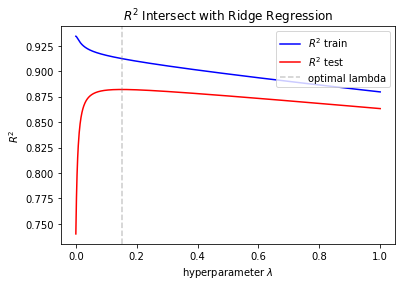

In [163]:
from sklearn.linear_model import Ridge
ridge = Ridge()
X = pd.get_dummies(houses.drop("SalePrice", axis=1), drop_first=True, dummy_na=True)
y = np.log(houses['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Test different alphas
alphas = np.linspace(.00001, 1, 1000)
ridge.set_params(normalize=True)
coefs  = []
scores = []
test_scores = []
for alpha in alphas:
        ridge.set_params(alpha=alpha)
        ridge.fit(X_train, y_train)  
        coefs.append(ridge.coef_)
        scores.append(ridge.score(X_train, y_train))
        test_scores.append(ridge.score(X_test, y_test))
coefs = pd.DataFrame(coefs, index = alphas, columns = X_train.columns) 

# Plot the R^2 scores for train and test
plt.plot(alphas, scores, c='b', label=r'$R^2$ train')
plt.plot(alphas, test_scores, c='r', label=r'$R^2$ test')
highest_test_score = alphas[np.array(test_scores) == max(test_scores)]
plt.axvline(highest_test_score, linestyle='--', color='grey', label='optimal lambda', alpha=0.4)
plt.legend(loc=1)
plt.title(r'$R^2$ Intersect with Ridge Regression')
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

ridge.set_params(normalize=True, alpha=highest_test_score)
ridge.fit(X_train, y_train)
print("The Ridge train score is: ", ridge.score(X_train, y_train))
print("The Ridge test score is: ", ridge.score(X_test, y_test))

In [167]:
X = pd.get_dummies(houses.drop("SalePrice", axis=1), drop_first=True, dummy_na=True)
y = np.log(houses['SalePrice'])
ridge.set_params(normalize=True, alpha=highest_test_score)
ridge.fit(X, y)
print("The Ridge train score is: ", ridge.score(X, y))
X_test = pd.get_dummies(test_houses, drop_first=True, dummy_na=True)
X_configure = X.head(10)
X_test = X_configure.append(X_test).fillna(0).drop(list(range(1, 11))).drop("MSSubClass_150", axis=1)
y_pred = ridge.predict(X_test)

The Ridge train score is:  0.9107653125911039


In [177]:
from math import exp
X_test["SalePrice"] = list(map(exp, y_pred))
X_test = X_test[["SalePrice"]]
answer_csv = test_index.merge(X_test, left_index=True, right_index=True, how="left")
answer_csv.loc[pd.isna(answer_csv["SalePrice"]), "SalePrice"] = houses.SalePrice.mean()
answer_csv.drop("Alley", axis=1, inplace=True)
answer_csv.to_csv("answers_3")